In [1]:
import json
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import shutil
import wandb

from collections import Counter, defaultdict
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import params

In [2]:
DATA_PATH = Path('data/')
TRAIN_DATA = DATA_PATH / 'multilabel_classification' / 'train.csv'
CATEGORY_KEYS = DATA_PATH / 'category_key.csv'
TRAIN_ANNOTATIONS = DATA_PATH / 'object_detection' / 'train.json'
EVAL_ANNOTATIONS = DATA_PATH / 'object_detection' / 'eval.json'
IMAGES_PATH = DATA_PATH / 'images'

In [4]:
with open(TRAIN_ANNOTATIONS, 'r') as f:
    train_data = json.load(f)

In [5]:
# First, I'll change the classes to take only those that appear

In [6]:
unique_categories = list(sorted(set(
    int(anno['category_id']) for anno in train_data['annotations']
)))

In [7]:
print(f'We observe {len(unique_categories)} categories')

We observe 133 categories


In [8]:
categories = train_data['categories']
categories[:5]

[{'id': 1, 'name': 'Actiniaria', 'supercategory': 'Anemone'},
 {'id': 2, 'name': 'Actinernus', 'supercategory': 'Anemone'},
 {'id': 3, 'name': 'Actiniidae', 'supercategory': 'Anemone'},
 {'id': 4, 'name': 'Actinoscyphia', 'supercategory': 'Anemone'},
 {'id': 5, 'name': 'Bolocera', 'supercategory': 'Anemone'}]

In [9]:
id2cat = {cat['id']:cat for cat in categories}

In [10]:
unique_categories[:10]

[1, 3, 7, 8, 9, 10, 11, 12, 13, 14]

In [11]:
old2new_cat = {
    old_cat: new_cat for (old_cat, new_cat) in  zip(unique_categories, range(len(unique_categories)))
}
new2old_cat = {
    new_cat: old_cat for (old_cat, new_cat) in old2new_cat.items()
}

In [12]:
with open('old2new_cat.json', 'w') as f:
    json.dump(old2new_cat, f)

with open('new2old_cat.json', 'w') as f:
    json.dump(new2old_cat, f)

In [13]:
new_categories = []
for category in unique_categories:
    old_category_dict = id2cat[category]
    new_category = old2new_cat[category]
    old_category_dict['id'] = new_category
    new_categories.append(old_category_dict)

In [14]:
new_categories[:5]

[{'id': 0, 'name': 'Actiniaria', 'supercategory': 'Anemone'},
 {'id': 1, 'name': 'Actiniidae', 'supercategory': 'Anemone'},
 {'id': 2, 'name': 'Hormathiidae', 'supercategory': 'Anemone'},
 {'id': 3, 'name': 'Isosicyonis', 'supercategory': 'Anemone'},
 {'id': 4, 'name': 'Liponema brevicorne', 'supercategory': 'Anemone'}]

In [15]:
processed_annos = []
for anno in train_data['annotations']:
    category_id = anno['category_id']
    new_anno = anno.copy()
    new_anno['category_id'] = old2new_cat[category_id]
    processed_annos.append(new_anno)

In [16]:
# In the initial phase I will randomly split images to train and val
# and only make sure all labels in the validation set are present
# in teh training

images_data = train_data['images']
all_labels_covered = False
while not all_labels_covered:
    train_images, val_images = train_test_split(images_data, test_size=0.2)
    train_image_ids = set(image_data['id'] for image_data in train_images)
    val_image_ids = set(image_data['id'] for image_data in val_images)
    train_annos = set()
    val_annos = set()
    for anno in processed_annos:
        if anno['image_id'] in val_image_ids:
            val_annos.add(anno['category_id'])
        else:
            train_annos.add(anno['category_id'])
    
    if len(val_annos - train_annos) == 0:
        all_labels_covered = True

In [17]:
print(f'Train set: {len(train_images)} images and {len(train_annos)} unique categories')
print(f'Val set: {len(val_images)} images and {len(val_annos)} unique categories')

Train set: 4760 images and 133 unique categories
Val set: 1190 images and 81 unique categories


In [18]:
train_annos = []
val_annos = []
for anno in processed_annos:
    if anno['image_id'] in val_image_ids:
        val_annos.append(anno)
    else:
        train_annos.append(anno)

In [19]:
# We see that some categories are not present in the validation set.

In [20]:
cat_images = defaultdict(set)
for anno in processed_annos:
    category_id = anno['category_id']
    image_id = anno['image_id']
    cat_images[category_id].add(image_id)
cat_image_counts = {int(cat): len(unique_images) for cat, unique_images in cat_images.items()}

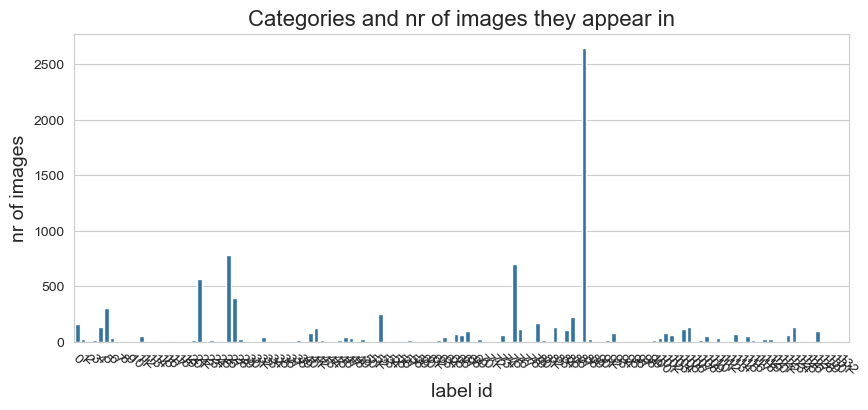

In [21]:
# Let's find out if we have labels with one occurence only
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(x=list(cat_image_counts.keys()), y=list(cat_image_counts.values()), ax=ax)

plt.title("Categories and nr of images they appear in", fontsize=16)
plt.xlabel("label id", fontsize=14)
plt.xticks(rotation=-45)
plt.ylabel("nr of images", fontsize=14)
plt.show()

In [22]:
# Now let's find number of categories per image occurrence

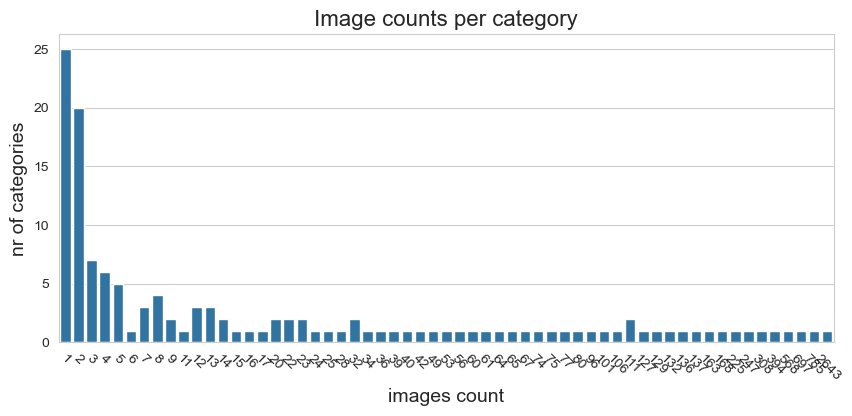

In [23]:
image_counts = Counter(cat_image_counts.values())

# Let's find out if we have labels with one occurence only
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), ax=ax)

plt.title("Image counts per category", fontsize=16)
plt.xlabel("images count", fontsize=14)
plt.xticks(rotation=-45)
plt.ylabel("nr of categories", fontsize=14)
plt.show()

# What we did here seems a bit complicated but it precisely show what we needed to see ;)
The x axis is the number of images occured per category and the y axis
is the amount of unique categories. We see that there's 25. categories which appear only in
one image. Then 20 that appear in 2.  
We probably need to find a cutting point for labels we will not be able to generalize on. In general,
a few hundered images with a label are required to properly generalize and detect the object. This can be
reduced if we have a pretrained model which can detect features and predict on them. I will first train 
a model on all labels and later remove those that appear less than 96 times.

This is something we will handle in the future.

In [24]:
train_data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [25]:
train_set = dict(
    info=train_data['info'],
    images=train_images,
    licenses=train_data['licenses'],
    annotations=train_annos,
    categories=new_categories
)
val_set = dict(
    info=train_data['info'],
    images=val_images,
    licenses=train_data['licenses'],
    annotations=val_annos,
    categories=new_categories
)

In [28]:
with open(DATA_PATH / 'train_data.json', 'w') as f:
    json.dump(train_set, f)
with open(DATA_PATH / 'val_data.json', 'w') as f:
    json.dump(val_set, f)

In [29]:
train_images_path = DATA_PATH / 'train'
if not os.path.exists(train_images_path):
    os.mkdir(train_images_path)
    print(f'Created directory {train_images_path}')
val_images_path = DATA_PATH / 'val'
if not os.path.exists(val_images_path):
    os.mkdir(val_images_path)
    print(f'Created directory {val_images_path}')

In [30]:
file_name = val_images[0]['file_name']
val_images_path / file_name

PosixPath('data/val/fb12b95f-bb2d-4b9c-853d-01d42e290957.png')

In [45]:
for image_data in tqdm(train_set['images']):
    file_name = image_data['file_name']
    shutil.copy(IMAGES_PATH / file_name, train_images_path / file_name)
for image_data in tqdm(val_set['images']):
    file_name = image_data['file_name']
    shutil.copy(IMAGES_PATH / file_name, val_images_path / file_name)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:02<00:00, 438.01it/s]


In [163]:
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type='data_split')

In [164]:
raw_data_at = run.use_artifact(f'{params.RAW_DATA_AT}:latest')
path = Path(raw_data_at.download())

wandb: Downloading large artifact fanthom_data_raw:latest, 16047.49MB. 11920 files... 
wandb:   11920 of 11920 files downloaded.  
Done. 0:0:6.9


In [165]:
original_table = raw_data_at.get('eda_table')

wandb: Downloading large artifact fanthom_data_raw:latest, 16047.49MB. 11920 files... 
wandb:   11920 of 11920 files downloaded.  
Done. 0:0:6.7


In [146]:
train_df = pd.DataFrame([train_img['file_name'].split('.')[0] for train_img in train_images], columns=['file_name'])
train_df['stage'] = 'train'
val_df = pd.DataFrame([val_img['file_name'].split('.')[0] for val_img in val_images], columns=['file_name'])
val_df['stage'] = 'val'

In [147]:
staged_data = pd.concat([train_df, val_df])
staged_data.to_csv(DATA_PATH / 'split_data.csv', index=False)

In [166]:
staged_data[staged_data.file_name==original_table.get_column('file_name')[0]]

,file_name,stage
999,3b6f01ae-5bde-434d-9b06-79b269421ed6,train


In [167]:
processed_data_at = wandb.Artifact(params.PROCESSED_DATA_AT, type='split_data')

In [168]:
processed_data_at.add_file(DATA_PATH / 'split_data.csv')

ArtifactManifestEntry(path='split_data.csv', digest='KZ9oXuMnnKBATlpHB+J52A==', ref=None, birth_artifact_id=None, size=253486, extra={}, local_path='/Users/matthewzak/Library/Application Support/wandb/artifacts/staging/tmpsvu427u5')

In [169]:
table = wandb.Table(dataframe=staged_data)

In [170]:
joined_table = wandb.JoinedTable(original_table, table, 'file_name')

In [171]:
processed_data_at.add(joined_table, 'eda_table_data_split')

ArtifactManifestEntry(path='eda_table_data_split.joined-table.json', digest='LXntIoOTyO+hPHUj04JEGw==', ref=None, birth_artifact_id=None, size=123, extra={}, local_path='/Users/matthewzak/Library/Application Support/wandb/artifacts/staging/tmpirvtxhq6')

In [172]:
run.log_artifact(processed_data_at)

In [173]:
run.finish()